In [1]:
# IMPORT STATEMENTS AND PRELIMINARIES

import numpy as np
import csv
import matplotlib.pyplot as plt
from   scipy import stats
from   alderaan.constants import *
import alderaan.io as io


In [2]:
MAINPATH = '/Users/research/projects/alderaan/'
CSV_FILE = MAINPATH + 'Catalogs/cumulative_20210416.csv'

# Read in exoplanet archive cumulative KOI data

In [3]:
keys, vals = io.read_csv_file(CSV_FILE, k_index=75, v_index=76)

# put these csv data into a dictionary
arc = {}
for k in keys: 
    arc[k] = io.get_csv_data(k, keys, vals)
    arc[k] = np.asarray(arc[k])

    if (arc[k].dtype == "<U1") or (arc[k].dtype == "<U2"):
        arc[k] = np.asarray(arc[k], dtype="<U3")
        
k0 = "kepid"
    
print("Loaded {0} real KOIs".format(len(arc[k0])))

Loaded 9564 real KOIs


In [4]:
# replace missing data with NaN
for k in arc.keys():
    arc[k][arc[k] == ""] = "nan"

In [5]:
# convert numerical arrays to floats
for k in arc.keys():
    try:
        arc[k] = np.asarray(arc[k], dtype="float")
    except:
        pass

# Read in Gaia DR2

In [6]:
gaiapath = MAINPATH + "Catalogs/berger_2020_gaia_kepler_tab2_output.txt"

# read in the stellar output parameters
with open(gaiapath, "r") as infile:
    raw_gaia_data = []
    
    for i, line in enumerate(infile):
        raw_gaia_data.append(line.split("&"))
            
raw_gaia_data = np.array(raw_gaia_data)


# strip off trailing \newline commands
for i in range(len(raw_gaia_data)):
    raw_gaia_data[i,-1] = raw_gaia_data[i,-1].strip("\n").strip("\ ")

In [7]:
raw_gaia_dict = {}

for i, k in enumerate(raw_gaia_data[0]):
    raw_gaia_dict[k] = raw_gaia_data[1:,i]

In [8]:
gaia = {}

gaia['kic']          = raw_gaia_dict['KIC']

gaia['Mstar']        = raw_gaia_dict['iso_mass']
gaia['Mstar_err1']   = raw_gaia_dict['iso_mass_err1']
gaia['Mstar_err2']   = raw_gaia_dict['iso_mass_err2']

gaia['Rstar']        = raw_gaia_dict['iso_rad']
gaia['Rstar_err1']   = raw_gaia_dict['iso_rad_err1']
gaia['Rstar_err2']   = raw_gaia_dict['iso_rad_err2']

gaia['logrho']      = raw_gaia_dict['iso_rho']
gaia['logrho_err1'] = raw_gaia_dict['iso_rho_err1']
gaia['logrho_err2'] = raw_gaia_dict['iso_rho_err2']

gaia['Teff']         = raw_gaia_dict['iso_teff']
gaia['Teff_err1']    = raw_gaia_dict['iso_teff_err1']
gaia['Teff_err2']    = raw_gaia_dict['iso_teff_err2']

gaia['FeH']          = raw_gaia_dict['iso_feh']
gaia['FeH_err1']     = raw_gaia_dict['iso_feh_err1']
gaia['FeH_err2']     = raw_gaia_dict['iso_feh_err2']

gaia['logg']          = raw_gaia_dict['iso_logg']
gaia['logg_err1']     = raw_gaia_dict['iso_logg_err1']
gaia['logg_err2']     = raw_gaia_dict['iso_logg_err2']

# Remove false-positives, low SNR objects, and monotransits

In [9]:
# remove false positives from DR25
fp = arc['koi_disposition'] == 'FALSE POSITIVE'
fp += (arc['koi_disposition'] != 'CONFIRMED')*(arc['koi_pdisposition'] == 'FALSE POSITIVE')

for k in arc.keys():
    arc[k] = arc[k][~fp]

print('after removing false positives, cumulative archive KOIs =', len(arc[k]))

after removing false positives, cumulative archive KOIs = 4724


In [10]:
# cut non-confirmed low signal-to-noise objects (SNR < 7.1)
arc_snr = arc['koi_model_snr']
#arc_snr[arc_snr == ''] = 0
arc_snr = np.array(arc_snr, dtype='float')

disposition = arc['koi_disposition']
npl = np.array(arc['koi_count'], dtype="int")

for k in arc.keys():
    bad = (arc_snr < 7.1)*(disposition != 'CONFIRMED')*(npl < 2)
    
    arc[k] = arc[k][~bad]
    
print('after removing unconfirmed objects with SNR < 7.1, KOIs =', len(arc[k]))

after removing unconfirmed objects with SNR < 7.1, KOIs = 4584


In [11]:
# cut very long period transits (period > 730)
arc_per = arc['koi_period']
#arc_per[arc_per == ''] = 1e6
arc_per = np.array(arc_per, dtype='float')

npl = np.array(arc['koi_count'], dtype="int")

bad = (arc_per > 730)*(npl < 2)

for k in arc.keys():
    arc[k] = arc[k][~bad]
    
    
print('after removing objects with P > 730 days, KOIs =', len(arc[k]))

after removing objects with P > 730 days, KOIs = 4577


In [12]:
# remove objects with fewer than three transits
arc_num_transits = arc["koi_num_transits"]
#arc_num_transits[arc_num_transits == ''] = 0
arc_num_transits = np.array(arc_num_transits, dtype='int')

npl = np.array(arc['koi_count'], dtype="int")

bad = (arc_num_transits < 3)*(npl < 2)

for k in arc.keys():
    arc[k] = arc[k][~bad]

print('after removing objects with fewer than three transits, KOIs =', len(arc[k]))

after removing objects with fewer than three transits, KOIs = 4297


# Initialize my catalog

In [13]:
Nobj = len(arc['kepid'])

In [14]:
my_catalog = {}

my_catalog['planet_name'] = arc['kepoi_name']
my_catalog['disposition'] = arc['koi_disposition']

my_catalog['koi_id']  = np.array(['K00000']*Nobj)
my_catalog['kic_id']  = np.array(arc['kepid'], dtype="int")

my_catalog['npl'] = np.array(arc['koi_count'], dtype="int")
my_catalog['kep_mag'] = np.array(arc['koi_kepmag'], dtype='float').round(3)

my_catalog['mstar'] = arc['koi_smass']
my_catalog['mstar_err1'] = arc['koi_smass_err1']
my_catalog['mstar_err2'] = arc['koi_smass_err2']

my_catalog['rstar'] = arc['koi_srad']
my_catalog['rstar_err1'] = arc['koi_srad_err1']
my_catalog['rstar_err2'] = arc['koi_srad_err2']

my_catalog['logrho'] = np.zeros_like(arc['koi_srad'])
my_catalog['logrho_err1'] = np.zeros_like(arc['koi_srad'])
my_catalog['logrho_err2'] = np.zeros_like(arc['koi_srad'])

my_catalog['Teff'] = arc['koi_steff']
my_catalog['Teff_err1'] = arc['koi_steff_err1']
my_catalog['Teff_err2'] = arc['koi_steff_err2']

my_catalog['FeH'] = arc['koi_smet']
my_catalog['FeH_err1'] = arc['koi_smet_err1']
my_catalog['FeH_err2'] = arc['koi_smet_err2']

my_catalog['logg'] = arc['koi_slogg']
my_catalog['logg_err1'] = arc['koi_slogg_err1']
my_catalog['logg_err2'] = arc['koi_slogg_err2']

my_catalog['limbdark_1'] = arc['koi_ldm_coeff1']
my_catalog['limbdark_2'] = arc['koi_ldm_coeff2']

my_catalog['period'] = arc['koi_period']
my_catalog['period_err1'] = arc['koi_period_err1']
my_catalog['period_err2'] = arc['koi_period_err2']

my_catalog['epoch'] = arc['koi_time0bk']
my_catalog['epoch_err1'] = arc['koi_time0bk_err1']
my_catalog['epoch_err2'] = arc['koi_time0bk_err2']

my_catalog['prad'] = arc['koi_prad']
my_catalog['prad_err1'] = arc['koi_prad_err1']
my_catalog['prad_err2'] = arc['koi_prad_err2']

my_catalog['impact'] = arc['koi_impact']
my_catalog['impact_err1'] = arc['koi_impact_err1']
my_catalog['impact_err2'] = arc['koi_impact_err2']

my_catalog['depth'] = arc['koi_depth']
my_catalog['depth_err1'] = arc['koi_depth_err1']
my_catalog['depth_err2'] = arc['koi_depth_err2']

my_catalog['duration'] = arc['koi_duration']
my_catalog['duration_err1'] = arc['koi_duration_err1']
my_catalog['duration_err2'] = arc['koi_duration_err2']

my_catalog['ror'] = arc['koi_ror']
my_catalog['ror_err1'] = arc['koi_ror_err1']
my_catalog['ror_err2'] = arc['koi_ror_err2']

my_catalog['dor'] = arc['koi_dor']
my_catalog['dor_err1'] = arc['koi_dor_err1']
my_catalog['dor_err2'] = arc['koi_dor_err2']

my_catalog['snr'] = arc['koi_model_snr']
my_catalog['num_transits'] = arc['koi_num_transits']

In [15]:
# make KOI name for star
for i, pname in enumerate(my_catalog['planet_name']):
    my_catalog['koi_id'][i] = pname[:-3]

# Enforce stellar parameter consistency

In [16]:
star_keys = ["kep_mag", "mstar", "rstar", "logrho", "limbdark_1", "limbdark_2"]


for sk in star_keys:
    for i, koi in enumerate(np.unique(my_catalog["koi_id"])):
        use = my_catalog["koi_id"] == koi

        if ~np.all(my_catalog[sk][use] == my_catalog[sk][use][0]):
            my_catalog[sk][use] = np.nanmean(my_catalog[sk][use])
            
            try:
                my_catalog[sk + "_err1"][use] = np.sqrt(np.nanmean(my_catalog[sk + "_err1"][use]**2))
                my_catalog[sk + "_err2"][use] = -np.sqrt(np.nanmean(my_catalog[sk + "_err2"][use]**2))
                
            except:
                pass

/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


In [17]:
# compute stellar densities
M = my_catalog["mstar"]
R = my_catalog["rstar"]
D = M/R**3*RHOSUN_GCM3

M_err1 = my_catalog["mstar_err1"]
R_err1 = my_catalog["rstar_err1"]
D_err1 = np.sqrt(((R**-3)*(M_err1))**2 + ((-3*M*R**-4)*(R_err1))**2)

M_err2 = my_catalog["mstar_err2"]
R_err2 = my_catalog["rstar_err2"]
D_err2 = -np.sqrt(((R**-3)*(M_err2))**2 + ((-3*M*R**-4)*(R_err2))**2)

my_catalog["logrho"] = np.log10(D)
my_catalog["logrho_err1"] = np.log10(D+D_err1) - my_catalog["logrho"]
my_catalog["logrho_err2"] = np.log10(D+D_err2) - my_catalog["logrho"]

/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


# Cross-match Kepler vs. Gaia and combine

#### This section uses Berger+ 2018 which only includes stellar radii; the catalog from Berger+ 2020 will soon be available and that will also include stellar masses

In [18]:
arc_kic = np.array(arc['kepid'], dtype='int')
gaia_kic = np.array(gaia['kic'], dtype='int')

len(arc_kic), len(gaia_kic)

(4297, 186301)

In [19]:
# update Kepler stellar properties to Gaia values where available
use = np.isin(arc_kic, gaia_kic)

for i, kic in enumerate(arc_kic):
    if use[i]:
        my_catalog['mstar'][i] = np.squeeze(gaia['Mstar'][gaia_kic == kic])
        my_catalog['mstar_err1'][i] = np.squeeze(gaia['Mstar_err1'][gaia_kic == kic])
        my_catalog['mstar_err2'][i] = np.squeeze(gaia['Mstar_err2'][gaia_kic == kic])

        my_catalog['rstar'][i] = np.squeeze(gaia['Rstar'][gaia_kic == kic])
        my_catalog['rstar_err1'][i] = np.squeeze(gaia['Rstar_err1'][gaia_kic == kic])
        my_catalog['rstar_err2'][i] = np.squeeze(gaia['Rstar_err2'][gaia_kic == kic])
                
        my_catalog['logg'][i] = np.squeeze(gaia['logg'][gaia_kic == kic])
        my_catalog['logg_err1'][i] = np.squeeze(gaia['logg_err1'][gaia_kic == kic])
        my_catalog['logg_err2'][i] = np.squeeze(gaia['logg_err2'][gaia_kic == kic])

        my_catalog['FeH'][i] = np.squeeze(gaia['FeH'][gaia_kic == kic])
        my_catalog['FeH_err1'][i] = np.squeeze(gaia['FeH_err1'][gaia_kic == kic])
        my_catalog['FeH_err2'][i] = np.squeeze(gaia['FeH_err2'][gaia_kic == kic])
        
        my_catalog['Teff'][i] = np.squeeze(gaia['Teff'][gaia_kic == kic])
        my_catalog['Teff_err1'][i] = np.squeeze(gaia['Teff_err1'][gaia_kic == kic])
        my_catalog['Teff_err2'][i] = np.squeeze(gaia['Teff_err2'][gaia_kic == kic])
        
        
        # density is a bit more complicated - Berger uses different notation convention than I do
        D = 10**float(np.squeeze(gaia['logrho'][gaia_kic == kic]))
        D_err1 = 10**float(np.squeeze(gaia['logrho_err1'][gaia_kic == kic]))
        D_err2 = -10**float(np.squeeze(gaia['logrho_err2'][gaia_kic == kic]))
        
        my_catalog["logrho"][i] = np.log10(D)
        my_catalog["logrho_err1"][i] = np.log10(D+D_err1) - my_catalog["logrho"][i]
        my_catalog["logrho_err2"][i] = np.log10(D+D_err2) - my_catalog["logrho"][i]

In [20]:
# enforce limb darkening consistency via averaging (some come from different places)
for i, koi in enumerate(my_catalog["koi_id"]):
    use = my_catalog["koi_id"] == koi
    
    my_catalog["limbdark_1"][use] = np.mean(my_catalog["limbdark_1"][use])
    my_catalog["limbdark_2"][use] = np.mean(my_catalog["limbdark_2"][use])

# Re-check stellar parameter consistency

In [21]:
star_keys = ["mstar", "rstar", "logrho"]

for sk in star_keys:
    for i, koi in enumerate(np.unique(my_catalog["koi_id"])):
        use = my_catalog["koi_id"] == koi

        if ~np.all(my_catalog[sk][use] == my_catalog[sk][use][0]):            
            my_catalog[sk][use] = np.nanmean(my_catalog[sk][use])
            my_catalog[sk + "_err1"][use] = np.sqrt(np.nanmean(my_catalog[sk + "_err1"][use]**2))
            my_catalog[sk + "_err2"][use] = -np.sqrt(np.nanmean(my_catalog[sk + "_err2"][use]**2))

/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


# Adjust number of planets in each system

In [22]:
# adjust number of planets in each system to reflect removals 
unique_systems = np.unique(my_catalog['koi_id'])

my_catalog['npl'] = np.zeros(len(my_catalog['koi_id']), dtype='int')

for us in unique_systems:
    new_npl = np.sum(my_catalog['koi_id'] == us)
    my_catalog['npl'][my_catalog['koi_id'] == us] = new_npl

(array([2442.,  978.,  498.,  244.,  110.,   18.,    7.,    0.]),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 8 Patch objects>)

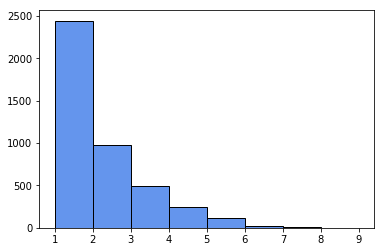

In [23]:
plt.hist(np.array(my_catalog['npl'], dtype='float'), bins=np.arange(1,10), color='cornflowerblue', edgecolor='k')

# Fix troublesome NaN values

In [60]:
bad = np.zeros(len(my_catalog["koi_id"]))

for k in my_catalog.keys():
    try:
        bad += np.isnan(my_catalog[k])
        
    except:
        pass


bad = bad > 0
print(my_catalog["koi_id"][bad])

['K00806' 'K00835' 'K00939' 'K00971' 'K01192' 'K01198' 'K01070' 'K00142'
 'K01316' 'K01445' 'K01445' 'K01423' 'K01639' 'K01576' 'K01576' 'K01665'
 'K01677' 'K01831' 'K02042' 'K01904' 'K01839' 'K01845' 'K01845' 'K01914'
 'K01988' 'K01922' 'K02001' 'K01858' 'K01862' 'K01803' 'K01877' 'K01940'
 'K01945' 'K01815' 'K02339' 'K02175' 'K02261' 'K02181' 'K02188' 'K02369'
 'K02364' 'K02222' 'K02224' 'K02225' 'K02311' 'K02311' 'K02081' 'K02160'
 'K02324' 'K02167' 'K02248' 'K02335' 'K02639' 'K02671' 'K00245' 'K00245'
 'K02610' 'K02768' 'K02768' 'K02743' 'K02758' 'K00377' 'K00377' 'K00331'
 'K03071' 'K00299' 'K00356' 'K00435' 'K00496' 'K01815' 'K00505' 'K00080'
 'K00099' 'K04388' 'K00672' 'K02220' 'K02193' 'K04098' 'K04109' 'K04215'
 'K03043' 'K04382' 'K04390' 'K04255' 'K04269' 'K04269' 'K03184' 'K04725'
 'K04647' 'K04713' 'K04676' 'K04839' 'K04772' 'K03311' 'K01101' 'K03206'
 'K04782' 'K04823' 'K03473' 'K03412' 'K02055' 'K03777' 'K03722' 'K03728'
 'K03891' 'K02879' 'K02061' 'K03478' 'K05801' 'K055

# Read out catalogue

In [ ]:
WRITENEW = True
if WRITENEW:
    filepath = MAINPATH + 'Catalogs/cumulative_koi_catalog.csv'

    with open(filepath, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(my_catalog.keys())
        writer.writerows(zip(*my_catalog.values()))

# Make condensed stellar parameter catalog

In [ ]:
stars = {}

stars["koi_id"] = []
stars["Teff"] = []
stars["Teff_err1"] = []
stars["Teff_err2"] = []
stars["logg"] = []
stars["logg_err1"] = []
stars["logg_err2"] = []
stars["FeH"] = []
stars["FeH_err1"] = []
stars["FeH_err2"] = []

for i, koi in enumerate(np.unique(my_catalog["koi_id"])):
    use = my_catalog["koi_id"] == koi
    
    stars["koi_id"].append(koi)
    
    for k in stars.keys():
        if k != "koi_id":
            stars[k].append(my_catalog[k][use][0])

In [ ]:
WRITENEW = True
if WRITENEW:
    filepath = MAINPATH + 'Catalogs/cumulative_koi_stellar.csv'

    with open(filepath, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(stars.keys())
        writer.writerows(zip(*stars.values()))